In [19]:
!pip install pandas_datareader

   ---------------------------------------- 0.0/109.5 kB ? eta -:--:--
   --- ------------------------------------ 10.2/109.5 kB ? eta -:--:--
   ------- ------------------------------- 20.5/109.5 kB 320.0 kB/s eta 0:00:01
   ---------- ---------------------------- 30.7/109.5 kB 325.1 kB/s eta 0:00:01
   --------------------- ----------------- 61.4/109.5 kB 409.6 kB/s eta 0:00:01
   -------------------------------------- 109.5/109.5 kB 576.9 kB/s eta 0:00:00


In [31]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB 1.3 MB/s eta 0:00:03
      --------------------------------------- 0.1/3.0 MB 656.4 kB/s eta 0:00:05
     - -------------------------------------- 0.1/3.0 MB 819.2 kB/s eta 0:00:04
     -- ------------------------------------- 0.2/3.0 MB 1.2 MB/s eta 0:00:03
     --- ------------------------------------ 0.3/3.0 MB 1.2 MB/s eta 0:00:03
     ---- ----------------------------------- 0.4/3.0 MB 1.3 MB/s eta 0:00:02
     ----- ---------------------------------- 0.4/3.0 MB 1.4 MB/s eta 0:00:02
     ------ --------------------------------- 0.5/3.0 MB 1.4 MB/s eta 0:00:02
     -------- ------------------------------- 0.6/3.0 MB 1.5 MB/s eta 0:00:02
     -------- ------------------------------- 0.7/3.0 MB 1.4 MB/s eta 0:00:02
     ----------- ---------------------------- 0.8/3.0 MB 1.6 MB/s eta 0:00:02
     ----------- ---------------------------- 0.8/3.0 MB 1.6 MB/s e

In [315]:
# import the libraries (make sure to install the libraries before importation)

import numpy as np
import yfinance as yf
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm




[*********************100%***********************]  1 of 1 completed


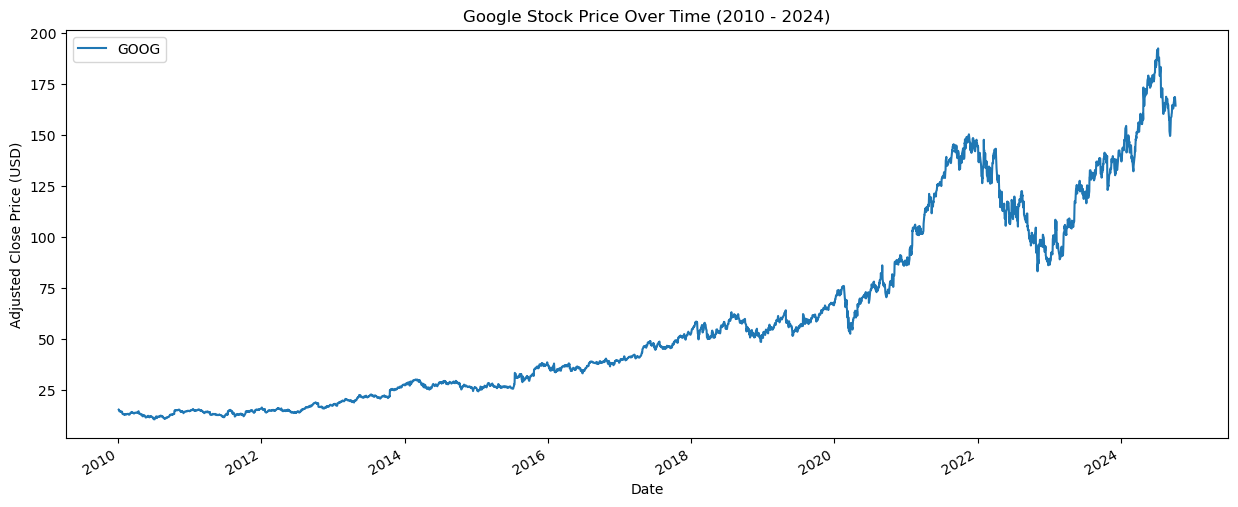

In [317]:

# Import your data
ticker = 'GOOG'
data = pd.DataFrame()
data[ticker] = yf.download(ticker, start='2010-01-01')['Adj Close']
# Plot
data.plot(figsize=(15,6))
#X and y labels
plt.title("Google Stock Price Over Time (2010 - 2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.show()


Text(0, 0.5, 'Frequency')

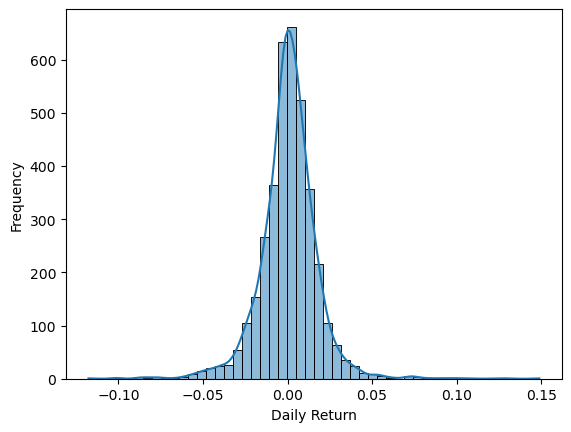

In [319]:

log_return = np.log(1 + data['GOOG'].pct_change())
# Drop any NaN values
log_return = log_return.dropna()

#Plot
sns.histplot(log_return, kde=True, bins=50)

plt.xlabel("Daily Return")
plt.ylabel("Frequency")

The figure above shows the distribution of the daily returns.
The data seems to be centered around the mean, but the data has outliers.

In [321]:
#We compute the drift term to analyzde the behavior of the daily returns
u = log_return.mean()
var = log_return.var()
drift = u - (0.5*var)


In [323]:
# We compute the variance and the daily returns to run the simulations
stdev = log_return.std()
days = 50
trials = 10000
Z = norm.ppf(np.random.rand(days, trials))
# Calculate daily returns using the drift and standard deviation
daily_returns = np.exp(drift + stdev * Z) #returns an array of random variables which we use for our simulations


In [325]:
#We then need to calculate a stock price for each trial that we are going to run in the simulations
price_paths = np.zeros_like(daily_returns)
price_paths[0] = data.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]

In [327]:
#We automate the process to run simulations on as many stocks as we may want
def import_stock_data(tickers, start='2010-01-01'):
    data = pd.DataFrame()
    if isinstance(tickers, str):  # If a single ticker is passed as a string
        tickers = [tickers]  # Convert to list to handle the single ticker case
    for t in tickers:
        data[t] = yf.download(t, start=start)['Adj Close']
    return data


data = import_stock_data(["META", "GOOG", "AAPL"], start='2005-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [329]:
#Calculate the log of returns
def log_returns(data):
    return (np.log(1+data.pct_change()))

log_return = log_returns(data)

In [331]:
#Calculate the drift
def drift_calc(data):
    lr = log_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

drift_calc(data)

array([0.00055763, 0.00062476, 0.00068619])

The function above shows 

In [275]:
def daily_returns(data, days, iterations):
    ft = drift_calc(data)  # Drift, assumed to have shape (3,)
    stv = log_returns(data).std()

    # Check if the standard deviation (stv) is a scalar or an array
    if np.isscalar(stv):
        stv = np.array(stv).reshape(1, 1, 1)  # Convert scalar to array and reshape for broadcasting
    else:
        stv = stv.values.reshape(-1, 1, 1)  # Reshape array for broadcasting

    # Reshape `ft` to (3, 1, 1) so it can broadcast with (3, 50, 1000)
    ft = ft.reshape(-1, 1, 1)

    # Generate random normal values and calculate returns
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    
    return dr


daily_returns(data,50,1000)

array([[[0.99874938, 1.02001676, 0.9955599 , ..., 1.03548746,
         0.96922286, 1.02245075],
        [1.01864688, 1.0236735 , 1.00220846, ..., 1.00971889,
         1.02066571, 0.97895735],
        [0.98895829, 0.96915193, 0.98270159, ..., 1.02534266,
         0.97523392, 1.03200707],
        ...,
        [1.05070836, 0.96268695, 1.0061234 , ..., 0.99980766,
         1.00756127, 1.00005943],
        [0.97207351, 1.0048272 , 1.03093404, ..., 0.96374426,
         0.95742235, 1.00894024],
        [1.03401039, 1.01081469, 1.02689218, ..., 0.94962766,
         0.96785643, 0.94067257]],

       [[0.9994046 , 1.0137311 , 0.99724755, ..., 1.02409189,
         0.97934912, 1.01536451],
        [1.01281124, 1.01618461, 1.00174146, ..., 1.0068063 ,
         1.01416672, 0.98598276],
        [0.99277573, 0.9793007 , 0.9885286 , ..., 1.01730359,
         0.98344794, 1.02176546],
        ...,
        [1.03423647, 0.97488303, 1.00438312, ..., 1.00011982,
         1.00535251, 1.00028994],
        [0.9

In [277]:
def market_data_combination(data, mark_ticker="^GSPC", start='2010-1-1'):
    # Import market data
    market_data = import_stock_data([mark_ticker], start=start)
    
    # Ensure that the indices match on date, and then combine the two datasets
    combined_data = data.join(market_data, how='inner')
    
    # Calculate the average market return (mean return of the market index)
    market_returns = log_returns(combined_data[[mark_ticker]])
    market_avg_return = market_returns.mean()[0]
    
    return combined_data, market_avg_return


In [279]:


def beta_sharpe(data, mark_ticker="^GSPC", start='2010-1-1', riskfree=0.025):
    # Combine data with market index
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    
    # Calculate annualized covariance and variance
    covar = log_ret.cov() * 252  # Annualized covariance
    covar = pd.DataFrame(covar.iloc[:-1, -1])  # Take covariance with market returns
    mrk_var = log_ret.iloc[:, -1].var() * 252  # Annualized market variance
    
    # Calculate Beta
    beta = covar / mrk_var
    beta.columns = ['Beta']  # Explicitly name the column as 'Beta'

    # Calculate standard deviation for Sharpe ratio
    stdev_ret = pd.DataFrame((log_ret.std() * 252**0.5)[:-1], columns=['STD'])  # Annualized std dev
    
    # Merge Beta and Standard Deviation (STD)
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # Calculate CAPM and Sharpe Ratio
    beta['CAPM'] = riskfree + (beta['Beta'] * (mark_ret - riskfree))
    beta['Sharpe'] = (beta['CAPM'] - riskfree) / beta['STD']
    
    # Debugging: Print the final DataFrame to verify the columns
    print(beta.head())

    return beta


# Example usage:
# Ensure `data` is a DataFrame with your asset's adjusted close prices, indexed by date
beta_sharpe(data, mark_ticker="^GSPC", start='2010-01-01')


[*********************100%***********************]  1 of 1 completed

          Beta       STD      CAPM    Sharpe
META  1.244798  0.400917 -0.005526 -0.076140
GOOG  1.133372  0.270823 -0.002793 -0.102626
AAPL  1.163661  0.281927 -0.003536 -0.101218



C:\Users\joyo\AppData\Local\Temp\ipykernel_68680\879783354.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_avg_return = market_returns.mean()[0]


,Beta,STD,CAPM,Sharpe
META,1.244798,0.400917,-0.005526,-0.076140
GOOG,1.133372,0.270823,-0.002793,-0.102626
AAPL,1.163661,0.281927,-0.003536,-0.101218


In [281]:
def probs_find(predicted, higherthan, on='value'):
    # Check if 'predicted' is a DataFrame with at least two rows and columns
    if predicted.empty or len(predicted) < 2:
        raise ValueError("The 'predicted' DataFrame must contain at least two rows for comparison.")
    
    # Handle the case when the 'on' parameter is 'return'
    if on == 'return':
        predicted0 = predicted.iloc[0, 0]  # Initial value for comparison (first row, first column)
        predicted_last = predicted.iloc[-1]  # Last row of the DataFrame
        predList = list(predicted_last)
        
        # Calculate returns relative to the initial value
        over = [i for i in predList if ((i - predicted0) * 100) / predicted0 >= higherthan]
        less = [i for i in predList if ((i - predicted0) * 100) / predicted0 < higherthan]
    
    # Handle the case when the 'on' parameter is 'value'
    elif on == 'value':
        predicted_last = predicted.iloc[-1]  # Last row of the DataFrame
        predList = list(predicted_last)
        
        # Compare predicted values to the higherthan threshold
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    

    else:
        raise ValueError("'on' must be either 'value' or 'return'")
    
  
    total_predictions = len(over) + len(less)
    if total_predictions == 0:
        return 0
    
    # Return the probability (proportion of 'over' values to total)
    return len(over) / total_predictions


probs_find(data, 0.5, on='return')


1.0

Price list at t=1: (1000, 3)
Returns at t=1: (1000, 3)
Price list at t=2: (1000, 3)
Returns at t=2: (1000, 3)
Price list at t=3: (1000, 3)
Returns at t=3: (1000, 3)
Price list at t=4: (1000, 3)
Returns at t=4: (1000, 3)
Price list at t=5: (1000, 3)
Returns at t=5: (1000, 3)
Price list at t=6: (1000, 3)
Returns at t=6: (1000, 3)
Price list at t=7: (1000, 3)
Returns at t=7: (1000, 3)
Price list at t=8: (1000, 3)
Returns at t=8: (1000, 3)
Price list at t=9: (1000, 3)
Returns at t=9: (1000, 3)
Price list at t=10: (1000, 3)
Returns at t=10: (1000, 3)
Price list at t=11: (1000, 3)
Returns at t=11: (1000, 3)
Price list at t=12: (1000, 3)
Returns at t=12: (1000, 3)
Price list at t=13: (1000, 3)
Returns at t=13: (1000, 3)
Price list at t=14: (1000, 3)
Returns at t=14: (1000, 3)
Price list at t=15: (1000, 3)
Returns at t=15: (1000, 3)
Price list at t=16: (1000, 3)
Returns at t=16: (1000, 3)
Price list at t=17: (1000, 3)
Returns at t=17: (1000, 3)
Price list at t=18: (1000, 3)
Returns at t=18: (1

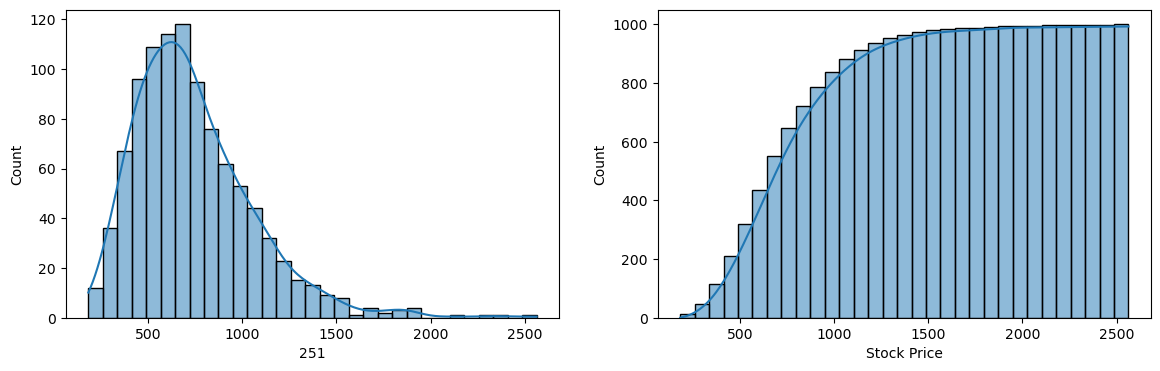

META
GOOG
AAPL
Days: 251
Expected Value: $741.97
Return: 20.08%
Probability of Breakeven: 0.639


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,...,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
1,595.039224,603.155742,572.187948,591.600289,596.047027,571.525850,610.578472,563.966820,597.911490,605.257557,...,600.980940,621.614299,578.277984,594.269165,586.247989,589.280328,603.744127,586.702780,594.933698,589.582757
2,563.211235,584.935668,584.215246,603.528044,582.043899,602.436843,623.144745,571.007877,590.898012,626.839490,...,578.483243,627.470562,601.464110,586.189581,565.575809,568.944076,606.404811,586.118559,578.400451,608.395130
3,585.432224,581.503948,578.423228,586.841547,580.494355,576.677052,607.000204,569.507520,583.677717,651.522875,...,596.112350,644.085052,606.747865,570.846646,567.959438,577.946637,598.192883,573.436062,582.785750,614.755827
4,571.889129,576.221624,579.665514,578.233951,564.523336,572.264256,604.073452,572.475707,570.855054,657.826754,...,577.189123,651.208054,611.582430,578.645027,562.017611,595.945953,563.660376,567.724324,579.695268,618.030054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,805.884477,616.160222,745.878762,855.655870,664.347717,350.451567,384.363461,790.350991,301.759485,972.181899,...,1033.508818,667.970427,947.341323,408.080314,422.573078,584.444452,897.942023,1068.243646,335.518137,979.239816
248,825.938532,599.060831,749.080621,868.328791,674.724966,365.914274,382.405374,787.735574,307.073058,980.085508,...,1069.565008,662.973665,962.874033,394.543912,422.076392,573.470715,921.471355,1084.581731,327.948516,1005.696775
249,848.347245,582.373625,726.074893,907.169192,678.942217,349.707962,389.003783,800.627071,304.098171,999.906020,...,1062.320690,630.603521,961.187144,398.671748,453.376204,558.598323,931.905200,1095.092152,329.402643,1005.049283
250,861.545562,586.842825,701.619916,895.212017,653.303559,357.629077,377.443255,819.359362,304.856242,988.492290,...,1060.128515,639.577439,1003.764816,403.596447,455.142135,538.199889,925.538398,1125.955296,329.802435,1058.312240


In [301]:
def daily_returns(data, days, iterations):
    # Calculate the daily percentage returns for each stock
    log_returns = np.log(1 + data.pct_change()).dropna()  # Compute log returns
    mean_returns = log_returns.mean().values
    std_returns = log_returns.std().values
    num_stocks = len(data.columns)

    # Generate random returns for each stock over the simulation period
    simulated_returns = np.random.normal(loc=mean_returns, scale=std_returns, size=(days, iterations, num_stocks))
    
    return simulated_returns

def simulate_mc(data, days, iterations, plot=True):
    num_stocks = len(data.columns)

    # Generate daily returns with the correct shape (days, iterations, num_stocks)
    returns = daily_returns(data, days, iterations)

    # Create an empty 3D matrix for price simulation: (days, iterations, num_stocks)
    price_list = np.zeros((days, iterations, num_stocks))

    # Initialize with the last prices for each stock
    last_prices = data.iloc[-1].values
    price_list[0, :, :] = last_prices  # Set last prices for each stock across all iterations

    # Calculate the price for each day and stock
    for t in range(1, days):
        print(f"Price list at t={t}: {price_list[t-1].shape}")
        print(f"Returns at t={t}: {returns[t].shape}")  # Updated to access correct slice
        price_list[t] = price_list[t-1] * (1 + returns[t])  # Multiply prices by (1 + daily returns)

    # Plotting Option
    if plot:
        # Example: plotting the last day's prices for the first stock
        x = pd.DataFrame(price_list[:, :, 0]).iloc[-1]  # Get the last day's prices for the first stock
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        sns.histplot(x, kde=True, ax=ax[0])  # Use histplot instead of distplot
        sns.histplot(x, cumulative=True, kde=True, ax=ax[1])  # Use histplot instead of distplot
        plt.xlabel("Stock Price")
        plt.show()

    # Printing information about stocks
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)

    print(f"Days: {days - 1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list[:, :, 0]).iloc[-1].mean(), 2)}")  # First stock example
    print(f"Return: {round(100 * (pd.DataFrame(price_list[:, :, 0]).iloc[-1].mean() - price_list[0, 0, 0]) / pd.DataFrame(price_list[:, :, 0]).iloc[-1].mean(), 2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list[:, :, 0]), 0, on='return')}")

    return pd.DataFrame(price_list[:, :, 0])  # Returning prices for the first stock as an example

# Example use
simulate_mc(data, 252, 1000, plot=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\joyo\AppData\Local\Temp\ipykernel_68680\879783354.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_avg_return = market_returns.mean()[0]


          Beta       STD      CAPM    Sharpe
META  1.275672  0.380980 -0.006358 -0.082308
GOOG  1.143427  0.284237 -0.003107 -0.098886
AAPL  1.196240  0.286877 -0.004405 -0.102502
Price list at t=1: (10000, 1)
Returns at t=1: (10000, 1)
Price list at t=2: (10000, 1)
Returns at t=2: (10000, 1)
Price list at t=3: (10000, 1)
Returns at t=3: (10000, 1)
Price list at t=4: (10000, 1)
Returns at t=4: (10000, 1)
Price list at t=5: (10000, 1)
Returns at t=5: (10000, 1)
Price list at t=6: (10000, 1)
Returns at t=6: (10000, 1)
Price list at t=7: (10000, 1)
Returns at t=7: (10000, 1)
Price list at t=8: (10000, 1)
Returns at t=8: (10000, 1)
Price list at t=9: (10000, 1)
Returns at t=9: (10000, 1)
Price list at t=10: (10000, 1)
Returns at t=10: (10000, 1)
Price list at t=11: (10000, 1)
Returns at t=11: (10000, 1)
Price list at t=12: (10000, 1)
Returns at t=12: (10000, 1)
Price list at t=13: (10000, 1)
Returns at t=13: (10000, 1)
Price list at t=14: (10000, 1)
Returns at t=14: (10000, 1)
Price list a

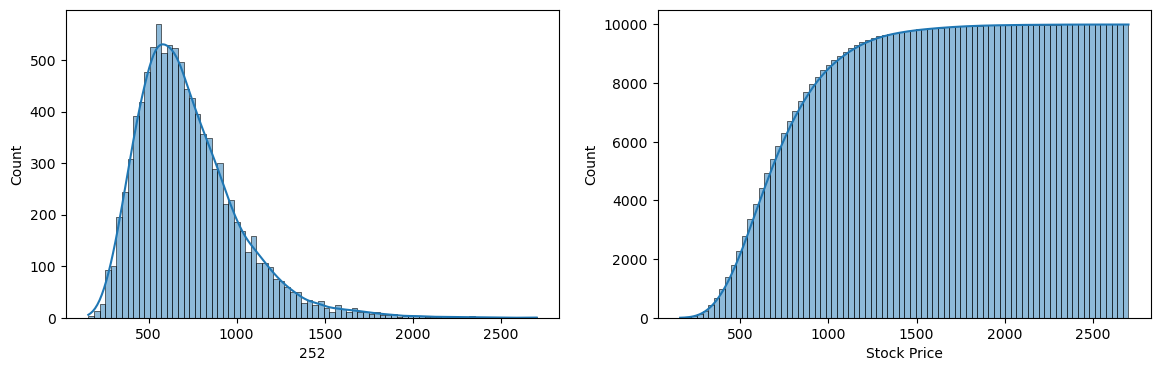

META
Days: 252
Expected Value: $724.18
Return: 18.39%
Probability of Breakeven: 0.6333
Beta: 1.28
Sharpe: -0.08
CAPM Return: -0.64%
Price list at t=1: (10000, 1)
Returns at t=1: (10000, 1)
Price list at t=2: (10000, 1)
Returns at t=2: (10000, 1)
Price list at t=3: (10000, 1)
Returns at t=3: (10000, 1)
Price list at t=4: (10000, 1)
Returns at t=4: (10000, 1)
Price list at t=5: (10000, 1)
Returns at t=5: (10000, 1)
Price list at t=6: (10000, 1)
Returns at t=6: (10000, 1)
Price list at t=7: (10000, 1)
Returns at t=7: (10000, 1)
Price list at t=8: (10000, 1)
Returns at t=8: (10000, 1)
Price list at t=9: (10000, 1)
Returns at t=9: (10000, 1)
Price list at t=10: (10000, 1)
Returns at t=10: (10000, 1)
Price list at t=11: (10000, 1)
Returns at t=11: (10000, 1)
Price list at t=12: (10000, 1)
Returns at t=12: (10000, 1)
Price list at t=13: (10000, 1)
Returns at t=13: (10000, 1)
Price list at t=14: (10000, 1)
Returns at t=14: (10000, 1)
Price list at t=15: (10000, 1)
Returns at t=15: (10000, 1)
P

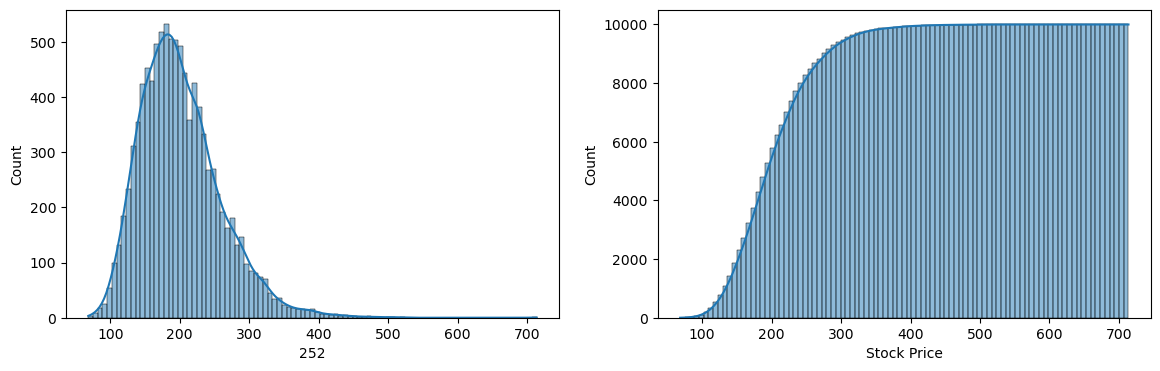

GOOG
Days: 252
Expected Value: $201.44
Return: 17.36%
Probability of Breakeven: 0.7042
Beta: 1.14
Sharpe: -0.1
CAPM Return: -0.31%
Price list at t=1: (10000, 1)
Returns at t=1: (10000, 1)
Price list at t=2: (10000, 1)
Returns at t=2: (10000, 1)
Price list at t=3: (10000, 1)
Returns at t=3: (10000, 1)
Price list at t=4: (10000, 1)
Returns at t=4: (10000, 1)
Price list at t=5: (10000, 1)
Returns at t=5: (10000, 1)
Price list at t=6: (10000, 1)
Returns at t=6: (10000, 1)
Price list at t=7: (10000, 1)
Returns at t=7: (10000, 1)
Price list at t=8: (10000, 1)
Returns at t=8: (10000, 1)
Price list at t=9: (10000, 1)
Returns at t=9: (10000, 1)
Price list at t=10: (10000, 1)
Returns at t=10: (10000, 1)
Price list at t=11: (10000, 1)
Returns at t=11: (10000, 1)
Price list at t=12: (10000, 1)
Returns at t=12: (10000, 1)
Price list at t=13: (10000, 1)
Returns at t=13: (10000, 1)
Price list at t=14: (10000, 1)
Returns at t=14: (10000, 1)
Price list at t=15: (10000, 1)
Returns at t=15: (10000, 1)
Pr

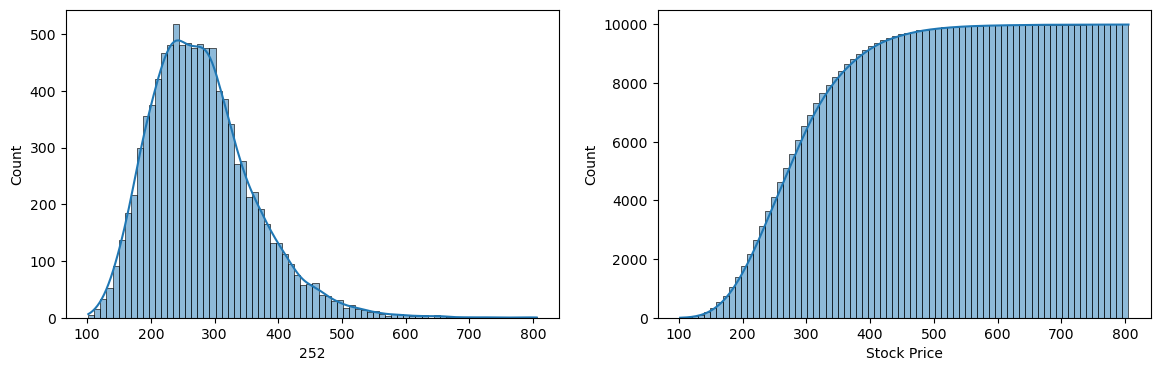

AAPL
Days: 252
Expected Value: $280.8
Return: 20.26%
Probability of Breakeven: 0.7422
Beta: 1.2
Sharpe: -0.1
CAPM Return: -0.44%


In [305]:
def monte_carlo(tickers, days_forecast, iterations, start_date='2000-01-01', plotten=False):
    data = import_stock_data(tickers, start=start_date)
    inform = beta_sharpe(data, mark_ticker="^GSPC", start=start_date)
    simulatedDF = []
    
    # Check if the columns "Beta", "Sharpe", and "CAPM" exist in 'inform'
    if not all(col in inform.columns for col in ['Beta', 'Sharpe', 'CAPM']):
        raise KeyError("One or more required columns ('Beta', 'Sharpe', 'CAPM') are missing from 'inform'.")

    for t in range(len(tickers)):
        # Use double brackets to keep the data as a DataFrame
        y = simulate_mc(data[[tickers[t]]], (days_forecast + 1), iterations)  # Adjusted here
        
        if plotten:
            forplot = y.iloc[:, 0:10]
            forplot.plot(figsize=(15, 4))
        
        # Using .loc[] to avoid indexing errors
        print(f"Beta: {round(inform.loc[tickers[t], 'Beta'], 2)}")
        print(f"Sharpe: {round(inform.loc[tickers[t], 'Sharpe'], 2)}")
        print(f"CAPM Return: {round(100 * inform.loc[tickers[t], 'CAPM'], 2)}%")
        
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]  # Move 'ticker' to the first column
        y = y[cols]
        simulatedDF.append(y)
    
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF

# Example use
ret_sim_df = monte_carlo(["META", "GOOG", "AAPL"], 252, 10000, start_date='2015-1-1')

